In [42]:
import osmnx as ox
import shapely
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.sparse import csr_matrix

%matplotlib inline

In [2]:
def convert_coordinates(eas,nor):
    # This function converts vl95 coordinates to wgs84 coordinates using an API from swisstopo
    import os

    api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(nor,eas)

    response = requests.get(api_url)
    return(float(response.json()['easting']),float(response.json()['northing']))

    return(koord_df_wgs84)

In [13]:
def save_numpy_array(np_arr,SAVEFILE_NAME):
    # This function stores the numpy array in the current directory
    with open('../data/processed/{}.npy'.format(SAVEFILE_NAME), 'wb') as f:
        np.save(f, np_arr)
    return()

def load_numpy_array(SAVEFILE_NAME):
    # This function loads the numpy array from the current directory
    with open('../data/processed/{}.npy'.format(SAVEFILE_NAME), 'rb') as f:
        return(np.load(f)) 

def convert_coordinates_multiple(koord_df,SAVEFILE_NAME):
    # This function converts vl95 coordinates to wgs84 coordinates using an API from swisstopo
    import os

    if os.path.exists('../data/processed/{}.npy'.format(SAVEFILE_NAME)):
        print("Savefile found. Loading coordinates from savefile.")
        koord_df_wgs84 = load_numpy_array(SAVEFILE_NAME)

    else:
        koord_df_wgs84 = np.empty(koord_df.shape,dtype='float')
        for i in range(koord_df.shape[0]):

            api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(koord_df[i,1],koord_df[i,0])

            response = requests.get(api_url)
            koord_df_wgs84[i,0] = float(response.json()['easting'])
            koord_df_wgs84[i,1] = float(response.json()['northing'])

            save_numpy_array(koord_df_wgs84,SAVEFILE_NAME)
    return(koord_df_wgs84)

## Load street network of zurichs district 9:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


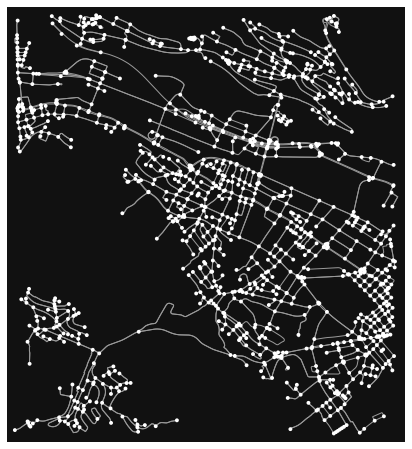

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
G = ox.graph_from_bbox(47.35834061900655, 47.4096315748066, 8.447603623951219, 8.516244330975884, network_type='drive') # bike
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

## Load all addresses located in zurichs district 9:

In [9]:
# Read dataset 'Adressen'

PATH_ADRESSEN = '../data/raw/geoz.adrstzh_adressen_stzh_p.csv'
df_adressen=pd.read_csv(PATH_ADRESSEN)

# Rename coordinates
df_adressen.rename(columns={"hausnummer_koord_ost":"koord_ost","hausnummer_koord_nord":"koord_nord"},inplace=True)

# select addresses from district 9
df_adressen = df_adressen[df_adressen.stadtkreis == 9]

#df_adressen.head()

## Convert coordinates from vl95 coordinates to wgs84 coordinates:

In [14]:
koord_adressen = df_adressen[['koord_nord','koord_ost']].to_numpy()
SAVEFILE_NAME = 'Koordinaten_Adressen_WGS84'
koord_adressen_wgs84 = convert_coordinates_multiple(koord_adressen,SAVEFILE_NAME)

adresses = pd.DataFrame(koord_adressen_wgs84,columns=["x","y"])
adresses

Savefile found. Loading coordinates from savefile.


,x,y
0,8.488178,47.381380
1,8.488689,47.381916
2,8.488650,47.382898
3,8.488726,47.383038
4,8.488812,47.383269
...,...,...
6570,8.498992,47.393103
6571,8.484023,47.399317
6572,8.484081,47.399798
6573,8.484254,47.399615


## Plot adresses together with street network:

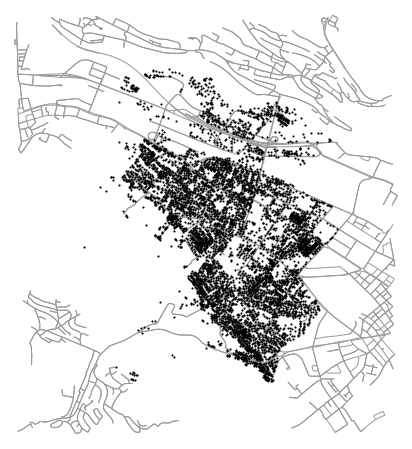

In [313]:
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c='k', marker='.', s=5, zorder=3)

fig.canvas.draw()
fig

# Now split addresses into groups using different clustering algorithms

### First, ignore the street network and perform a regular spatial clustering using kmeans for demonstration:

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="random",n_clusters=30,n_init=10,max_iter=300,random_state=42)

#kmeans.fit(np.deg2rad(adresses[['y', 'x']]))
kmeans.fit(adresses[['y', 'x']])

adresses['spatial_cluster'] = kmeans.labels_

KMeans(init='random', n_clusters=30, random_state=42)

Number of clusters: 30


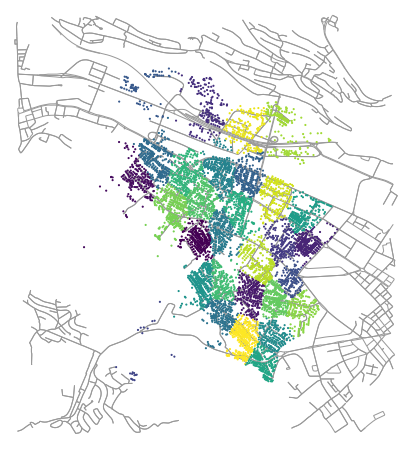

In [27]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'m', 3:'b'}
# point_colors = [color_map[c] for c in adresses['spatial_cluster']]
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['spatial_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
print("Number of clusters:",str(len(adresses['spatial_cluster'].unique())))
fig

## Second, cluster along the street network

### For this, we need to create a distance matrix first:

In [32]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, vs=nodes_unique):
    
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [33]:
# Attach nearest node to each address then make network-based distance matrix

# attach nearest network node to each adresses
adresses['nn'] = ox.nearest_nodes(G, X=adresses['x'], Y=adresses['y'])
print("Number of addresses:",len(adresses['nn']))

# we'll get distances for each pair of nodes that have adresses attached to them
nodes_unique = pd.Series(adresses['nn'].unique())
nodes_unique.index = nodes_unique.values
print("Number of nodes where adressess are attached to:",len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

Number of addresses: 6575
Number of nodes where adressess are attached to: 451


In [39]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
#node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm_s)
node_dm = node_dm.astype(int)
print('Size node_dm: ','{:,.0f}'.format(node_dm.size),'(',node_dm.shape[0],'x',node_dm.shape[1],'matrix)')

Size node_dm:  203,401 ( 451 x 451 matrix)
CPU times: user 5min 4s, sys: 1.39 s, total: 5min 5s
Wall time: 5min 6s


In [36]:
# Make distance matrix sparse

node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [40]:
# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=adresses['nn'], columns=adresses['nn'])
print('Size ndm: ','{:,.0f}'.format(ndm.size),'(',ndm.shape[0],'x',ndm.shape[1],'matrix)')

Size ndm:  43,230,625 ( 6575 x 6575 matrix)


In [43]:
%%time
# convert network-based distance matrix to a sparse matrix
ndm_sparse = csr_matrix(ndm)

CPU times: user 1.83 s, sys: 1.77 s, total: 3.6 s
Wall time: 3.87 s


In [45]:
# how much space does the dense matrix use, in MB?
dense_size = ndm.to_numpy().nbytes / 1e6
print('ndm size (bytes):',dense_size)

ndm size (bytes): 345.845


In [44]:
# how much space does the sparse matrix use, in MB?
sparse_size = (ndm_sparse.data.nbytes + ndm_sparse.indptr.nbytes + ndm_sparse.indices.nbytes) / 1e6
print('ndm_sparse size (bytes):',sparse_size)

ndm_sparse size (bytes): 517.126032


## Cluster adresses along the network

In [71]:
from sklearn.cluster import DBSCAN

# parameterize DBSCAN
eps = 150 #meters
minpts = 120 #smallest cluster size allowed

In [72]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=minpts, metric='precomputed')
adresses['network_cluster'] = db.fit_predict(ndm_sparse)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neighbors/_base.py:176: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


CPU times: user 5.41 s, sys: 1.08 s, total: 6.49 s
Wall time: 6.56 s


Number of clusters: 26


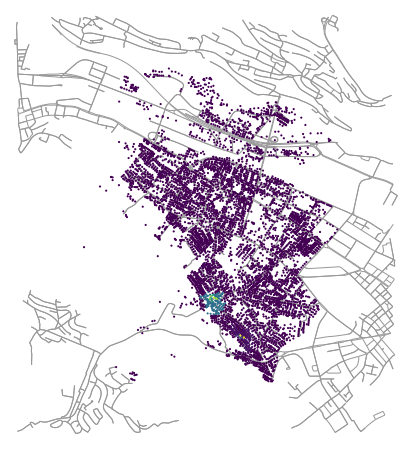

In [73]:
# plot adresses by cluster
# color_map = {-1:'gray', 0:'g', 1:'r', 2:'b', 3:'m', 4:'y', 5:'k', 6:'orange', 7:'pink'}
# point_colors = [color_map[c] for c in adresses['network_cluster']]
ns = [50 if n in adresses['nn'].values else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c=adresses['network_cluster'], marker='.', s=5, zorder=3)
fig.canvas.draw()
print("Number of clusters:",str(len(adresses['network_cluster'].unique())))
fig

# Save

In [ ]:
# save the graph to disk
ox.save_graph_geopackage(G, filepath='data/graph.gpkg')

In [ ]:
# save and show the clustered adresses data set
adresses = adresses.reindex(columns=['x', 'y', 'nn', 'spatial_cluster', 'network_cluster'])
adresses.to_csv('data/clustered.csv', encoding='utf-8', index=False)
adresses[10:15]